In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

In [2]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [3]:
base_cat = ['DM', 'eDM', 'PGC1', 'Vcmb']

[x+'_cat' for x in base_cat]

['DM_cat', 'eDM_cat', 'PGC1_cat', 'Vcmb_cat']

In [4]:
df = pd.read_csv("SBF_CF4_components_bar.csv", delimiter='|')

df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.set_index('PGC')

cat = 'SBF+'
df["DM_"+cat] = df.DM_av
df["eDM_"+cat] = df.eDM_av
df['PGC1_'+cat] = df.index
df['Vcmb_'+cat] = df["Vcmb"]
df_SBFCF4 = df[[x+'_'+cat for x in base_cat]]

print(len(df_SBFCF4))

df_SBFCF4.head()

425


,DM_SBF+,eDM_SBF+,PGC1_SBF+,Vcmb_SBF+
PGC,,,,
218,30.468,0.14,218,701.544501
1160,31.318,0.33,1160,804.882440
2004,24.258,0.16,2004,-455.615596
2329,23.838,0.16,2329,-463.091804
2555,24.368,0.08,2555,-486.492109


In [5]:
df = pd.read_csv('HST_IR_sbf.csv', delimiter='|')
df = df.rename(columns=lambda x: x.strip())
df = df.set_index('PGC')

ln10 = np.log(10.)
df['DM_SBFsnap']  = df["DM"]
df['eDM_SBFsnap'] = df["edm"]

df["Vcmb_SBFsnap"] = Vh2V3k(df["glon"], df["glat"], df["Vhel"])


cat = 'SBFsnap'
df["DM_"+cat] = df.DM
df["eDM_"+cat] = df.edm
df['PGC1_'+cat] = df.index
df_HSTIR = df[[x+'_'+cat for x in base_cat]]


df_HSTIR.head()

,DM_SBFsnap,eDM_SBFsnap,PGC1_SBFsnap,Vcmb_SBFsnap
PGC,,,,
1037,34.126,0.074,1037,5097.443600
3455,34.167,0.068,3455,4666.687342
3982,34.100,0.076,3982,4760.516577
4224,33.937,0.070,4224,4983.628463
5037,34.049,0.059,5037,3820.698741


In [6]:
df = pd.read_csv('FP_CF4_components_bar.csv', delimiter='|')
df["PGC1"] = df.apply(lambda x: x.PGC1 if x.PGC1 != 0 else x.PGC, axis=1)
df = df.set_index('PGC')

cat = 'FP+'
df["DM_"+cat] = df.DM_av
df["eDM_"+cat] = df.eDM_av
df['PGC1_'+cat] = df.index
df['Vcmb_'+cat] = df["Vcmb"]
df_FP = df[[x+'_'+cat for x in base_cat]]

print(len(df_FP))

df_FP.head()

42254


,DM_FP+,eDM_FP+,PGC1_FP+,Vcmb_FP+
PGC,,,,
64,36.555697,0.629727,64,15324.0
66,36.226167,0.586298,66,14725.0
114,35.450032,0.586298,114,14397.0
115,36.197557,0.586298,115,14005.0
123,35.844313,0.564583,123,10966.0


In [7]:
how = 'outer'

# df = df_SBFCF4.join(df_HSTIR, how=how)
df = df_SBFCF4.join(df_FP, how=how)

df.head()

,DM_SBF+,eDM_SBF+,PGC1_SBF+,Vcmb_SBF+,DM_FP+,eDM_FP+,PGC1_FP+,Vcmb_FP+
PGC,,,,,,,,
64,NaN,NaN,NaN,NaN,36.555697,0.629727,64.0,15324.0
66,NaN,NaN,NaN,NaN,36.226167,0.586298,66.0,14725.0
114,NaN,NaN,NaN,NaN,35.450032,0.586298,114.0,14397.0
115,NaN,NaN,NaN,NaN,36.197557,0.586298,115.0,14005.0
123,NaN,NaN,NaN,NaN,35.844313,0.564583,123.0,10966.0


In [8]:
catalogs = []
catalogs = ["SBF+"]
# catalogs += ["SBFsnap"]
catalogs += ["FP+"]


In [9]:
ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, "DM_"+cat, "eDM_"+cat, "Vcmb_"+cat]

df = df[ss]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]

print(len(df))

df.head()

42566


,PGC1_SBF+,DM_SBF+,eDM_SBF+,Vcmb_SBF+,PGC1_FP+,DM_FP+,eDM_FP+,Vcmb_FP+,pgc1
PGC,,,,,,,,,
64,NaN,NaN,NaN,NaN,64.0,36.555697,0.629727,15324.0,64.0
66,NaN,NaN,NaN,NaN,66.0,36.226167,0.586298,14725.0,66.0
114,NaN,NaN,NaN,NaN,114.0,35.450032,0.586298,14397.0,114.0
115,NaN,NaN,NaN,NaN,115.0,36.197557,0.586298,14005.0,115.0
123,NaN,NaN,NaN,NaN,123.0,35.844313,0.564583,10966.0,123.0


In [10]:
d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)
dg.replace([0], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

<ipython-input-10-d0c29ddfdc14>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2


In [11]:
# dg = df.groupby("pgc1").agg(["sum", "count"])
# dg.head()

In [12]:
def GfastChi2(dg, theta=None):
    
    if theta is None:
        d = np.zeros(len(catalogs))
    else:
        theta = np.asarray(theta)
        d = np.concatenate((np.zeros(1), theta[1:]))
    
    myDict = {}
    for i, cat in enumerate(catalogs):
        myDict[cat] = d[i]

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [13]:
t1 =  datetime.now()

print(GfastChi2(dg_, theta=range(len(catalogs))))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

339.49465254172924
Execution time:
0:00:00.027225


In [14]:
dg.head()

,N_SBF+,DMg_SBF+,eDMg_SBF+,N_FP+,DMg_FP+,eDMg_FP+
,,,,,,
pgc1,,,,,,
64,NaN,NaN,NaN,1.0,36.555697,0.629727
66,NaN,NaN,NaN,1.0,36.226167,0.586298
114,NaN,NaN,NaN,1.0,35.450032,0.586298
115,NaN,NaN,NaN,1.0,36.197557,0.586298
123,NaN,NaN,NaN,1.0,35.844313,0.564583


In [15]:
df

,PGC1_SBF+,DM_SBF+,eDM_SBF+,Vcmb_SBF+,PGC1_FP+,DM_FP+,eDM_FP+,Vcmb_FP+,pgc1,w_SBF+,xw_SBF+,w_FP+,xw_FP+
PGC,,,,,,,,,,,,,
64,NaN,NaN,NaN,NaN,64.0,36.555697,0.629727,15324.0,64.0,NaN,NaN,2.521711,92.182917
66,NaN,NaN,NaN,NaN,66.0,36.226167,0.586298,14725.0,66.0,NaN,NaN,2.909135,105.386801
114,NaN,NaN,NaN,NaN,114.0,35.450032,0.586298,14397.0,114.0,NaN,NaN,2.909135,103.128921
115,NaN,NaN,NaN,NaN,115.0,36.197557,0.586298,14005.0,115.0,NaN,NaN,2.909135,105.303571
123,NaN,NaN,NaN,NaN,123.0,35.844313,0.564583,10966.0,123.0,NaN,NaN,3.137218,112.451416
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5094035,NaN,NaN,NaN,NaN,5094035.0,38.682886,0.446470,29916.0,5094035.0,NaN,NaN,5.016669,194.059231
5094400,NaN,NaN,NaN,NaN,5094400.0,35.335934,0.527980,12259.0,5094400.0,NaN,NaN,3.587278,126.759825
5094420,NaN,NaN,NaN,NaN,5094420.0,36.012945,0.457390,22133.0,5094420.0,NaN,NaN,4.779986,172.141391


In [16]:
len(dg_)

42566

In [17]:
dg_.head()

,DMg_SBF+,DMg_FP+,eDMg_SBF+,eDMg_FP+,gw_SBF+,gw_FP+,gxw_SBF+,gxw_FP+,gxi2_SBF+,gxi2_FP+
,,,,,,,,,,
pgc1,,,,,,,,,,
64,NaN,36.555697,NaN,0.629727,NaN,2.521711,NaN,94.704628,NaN,0.0
66,NaN,36.226167,NaN,0.586298,NaN,2.909135,NaN,108.295936,NaN,0.0
114,NaN,35.450032,NaN,0.586298,NaN,2.909135,NaN,106.038056,NaN,0.0
115,NaN,36.197557,NaN,0.586298,NaN,2.909135,NaN,108.212706,NaN,0.0
123,NaN,35.844313,NaN,0.564583,NaN,3.137218,NaN,115.588634,NaN,0.0


In [18]:
len(df)

42566

In [19]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

In [20]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = len(catalogs), 128

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 5000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))



Execution time:
2:39:53.103781


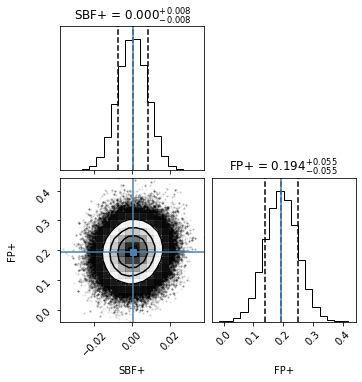

In [21]:
truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=catalogs, 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

In [22]:
npzName = "SBF_FP_groups.npz"
np.savez(npzName, samples)
npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
NPZsamples = npzfile['arr_0']

npz attributes:  ['arr_0']


In [23]:
mean = np.mean(NPZsamples[:,0])

mean

0.00016827855618866636

In [24]:
NPZsamples[:,0] -= mean

In [25]:
theta = map(lambda v: [v[1], v[2]-v[1], v[1]-v[0]],
                            zip(*np.percentile(NPZsamples, 
                            [16, 50, 84],
                            axis=0)))



theta

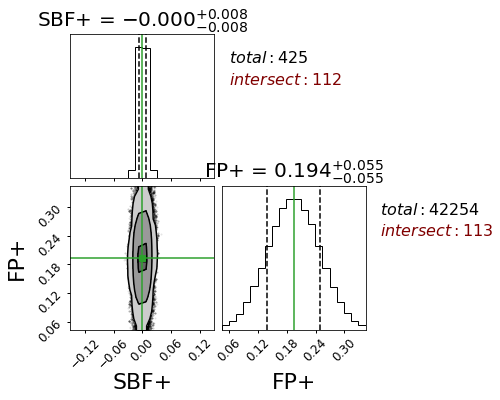

In [27]:
theta = map(lambda v: [v[1], v[2]-v[1], v[1]-v[0]],
                            zip(*np.percentile(NPZsamples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
truths[0] = 0

# labels = ['            '+r'$\Delta\/ \mu_{'+cat+'}$' for cat in ["Pantheonplus", "Scolnic", "CSP1", "Ganesh", "Rest+", "Amanullah", "Jha", "Prieto", "Hicken", "Folatelli"]] # catalogs[1:]]

fig = corner.corner(NPZsamples, labels=catalogs, 
                    truths=truths, truth_color='#2ca02c',
                    levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
                    show_titles=True, fill_contours=True, plot_density=True,
                    quantiles=[0.16, 0.84], 
                    scale_hist=False,space=0, 
                    title_kwargs={"fontsize": 20}, 
                    title_fmt=".3f",
                    range=[(t-0.15,t+0.15) for t in truths]
                   )

m = 0 
n_cat = len(catalogs)
i_cat = 0
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(50)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)    
    
    
    ax.tick_params(which='major', length=3, width=1., direction='out')
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.1*Xlm[0]+1.1*Xlm[1]
    
    if m%(n_cat+1)==0:
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        dx = df[['DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$total: $"+str(len(dx)), fontsize=16, color='k')
        
        y0 = 0.35*Ylm[0]+0.65*Ylm[1]
        other_DMs = ["DM_"+c for c in catalogs if c != catalogs[i_cat]]
        
        df["sumDM"] = df[other_DMs].sum(axis=1)
        df["sumDM"][df["sumDM"]==0] = np.nan
        
        dx = df[['sumDM', 'DM_'+catalogs[i_cat]]].dropna()       
        ax.text(x0,y0, r"$intersect: $"+str(len(dx)), fontsize=16, color='maroon')
        i_cat += 1


    m+=1

